In [3]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from typing import List
from utils import dump_dref

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1)
sns.set_palette("colorblind")

ll_o = Path("module/latest-ll-o")
bu_o = Path("module/latest-bu-o")
ll_c = Path("module/latest-ll-c")
bu_c = Path("module/latest-bu-c")

col_order = ["Bulk", "Rand", "Repeat"]


def read_orders(dir: str, orders: List[int]) -> pd.DataFrame:
    data = []
    for o in orders:
        d = pd.read_csv(f"{dir}/out_{o}.csv")
        d["order"] = o
        data.append(d)
    data = pd.concat(data)
    data["cores"] = data["x"]
    data["alloc"] = data["get_avg"]
    data["free"] = data["put_avg"]
    return data[["order", "cores", "iteration", "alloc", "free"]]


def read_all_bench(dir: Path, orders: List[int]) -> pd.DataFrame:
    data_b = read_orders(dir / "bulk", orders)
    data_b["bench"] = "Bulk"
    data_r = read_orders(dir / "repeat", orders)
    data_r["bench"] = "Repeat"
    data_r["free+alloc"] = data_r["alloc"]
    del data_r["alloc"]
    del data_r["free"]
    data_a = read_orders(dir / "rand", orders)
    data_a["bench"] = "Rand"
    del data_a["alloc"]
    return pd.concat([data_b, data_r, data_a])


def save_dref(name: str, groupby: List[str], data: pd.DataFrame):
    out = {}
    data = data.dropna(axis=0).groupby(groupby).mean(numeric_only=True)
    for index, row in data.iterrows():
        out["/".join(map(str, row.name))] = row.values[0]
    with Path(f"out/{name}.dref").open("w+") as f:
        dump_dref(f, name, out)


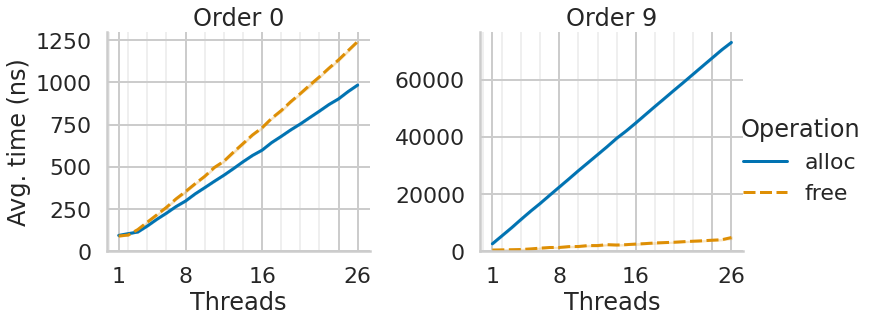

In [5]:
data_bu = read_orders(bu_c / "bulk", [0, 9])
pgd = data_bu.melt(
    id_vars=["order", "cores"],
    value_vars=["alloc", "free"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, col="order", aspect=1.1, height=5, sharey=False)
    g.map_dataframe(sns.lineplot, x="cores", y="time",
                    hue="Operation", style="Operation")

    g.add_legend(adjust_subtitles=True)
    g.legend.set_title("Operation")

    g.set(xticks=[1, 8, 16, 24, 26])
    for ax in g.axes_dict.values():
        ax.set_xticks(list(range(0, 27, 2)), minor=True)
        ax.grid(which="minor", alpha=0.3)
    g.set(xticklabels=[1, 8, 16, "", 26])

    g.set(ylim=(0, None))
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Threads")
    g.set_titles("Order {col_name}")
    g.axes_dict[9].set_ylabel("")
    g.savefig("out/buddy_threads.pdf")


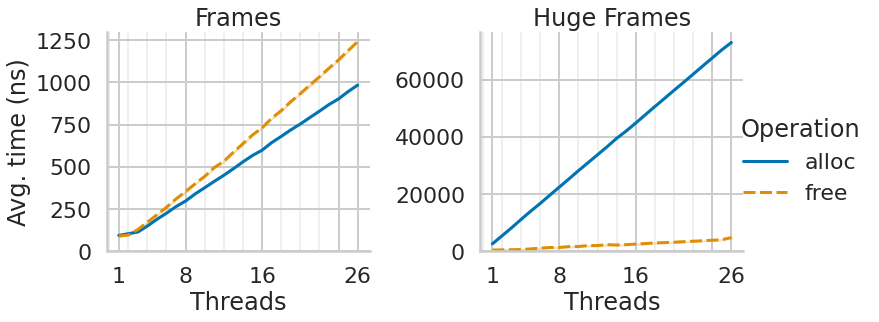

In [4]:
data_bu = read_orders(bu_c / "bulk", [0, 9])
pgd = data_bu.melt(
    id_vars=["order", "cores"],
    value_vars=["alloc", "free"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, col="order", aspect=1.1,
                      height=5, sharey=False)
    g.map_dataframe(sns.lineplot, x="cores", y="time",
                    hue="Operation", style="Operation")

    g.add_legend(adjust_subtitles=True)
    g.legend.set_title("Operation")

    g.set(xticks=[1, 8, 16, 24, 26])
    for ax in g.axes_dict.values():
        ax.set_xticks(list(range(0, 27, 2)), minor=True)
        ax.grid(which="minor", alpha=0.3)
    g.set(xticklabels=[1, 8, 16, "", 26])

    g.set(ylim=(0, None))
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Threads")
    g.set_titles("Order {col_name}")
    g.axes_dict[9].set_ylabel("")
    g.axes_dict[0].set_title("Frames")
    g.axes_dict[9].set_title("Huge Frames")
    g.savefig("out/buddy_threads_alt.pdf")


# Order Scaling

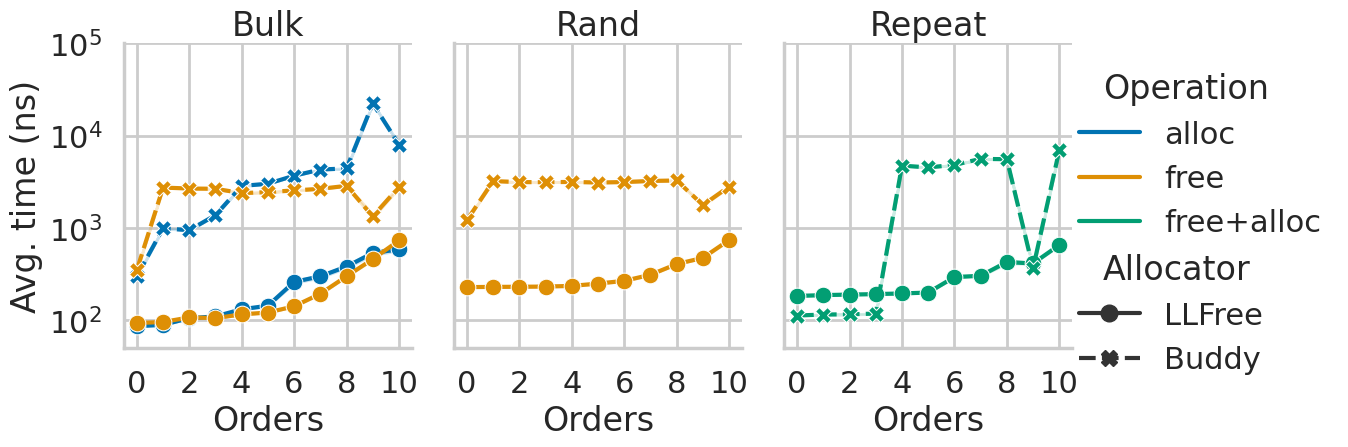

In [4]:
data_ll = read_all_bench(ll_o, list(range(11)))
data_ll["Allocator"] = "LLFree"
data_bu = read_all_bench(bu_o, list(range(11)))
data_bu["Allocator"] = "Buddy"

data_o = pd.concat([data_ll, data_bu], ignore_index=True)
pgd = data_o.melt(
    id_vars=["bench", "order", "Allocator"],
    value_vars=["alloc", "free", "free+alloc"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, col="bench", col_order=col_order, aspect=0.8, height=5)
    g.map_dataframe(sns.lineplot, x="order", y="time",
                    hue="Operation", style="Allocator", markers=True)
    g.add_legend(adjust_subtitles=True)
    # g.set(ylim=(None, 10000))
    g.set(ylim=(50, 10**5))
    g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Orders")
    g.set(xticks=[0, 2, 4, 6, 8, 10])
    g.set_titles("{col_name}")
    g.savefig("out/module_o.pdf")

save_dref("module_o", ["Allocator", "bench", "order", "Operation"], pgd)


# Multicore Scaling

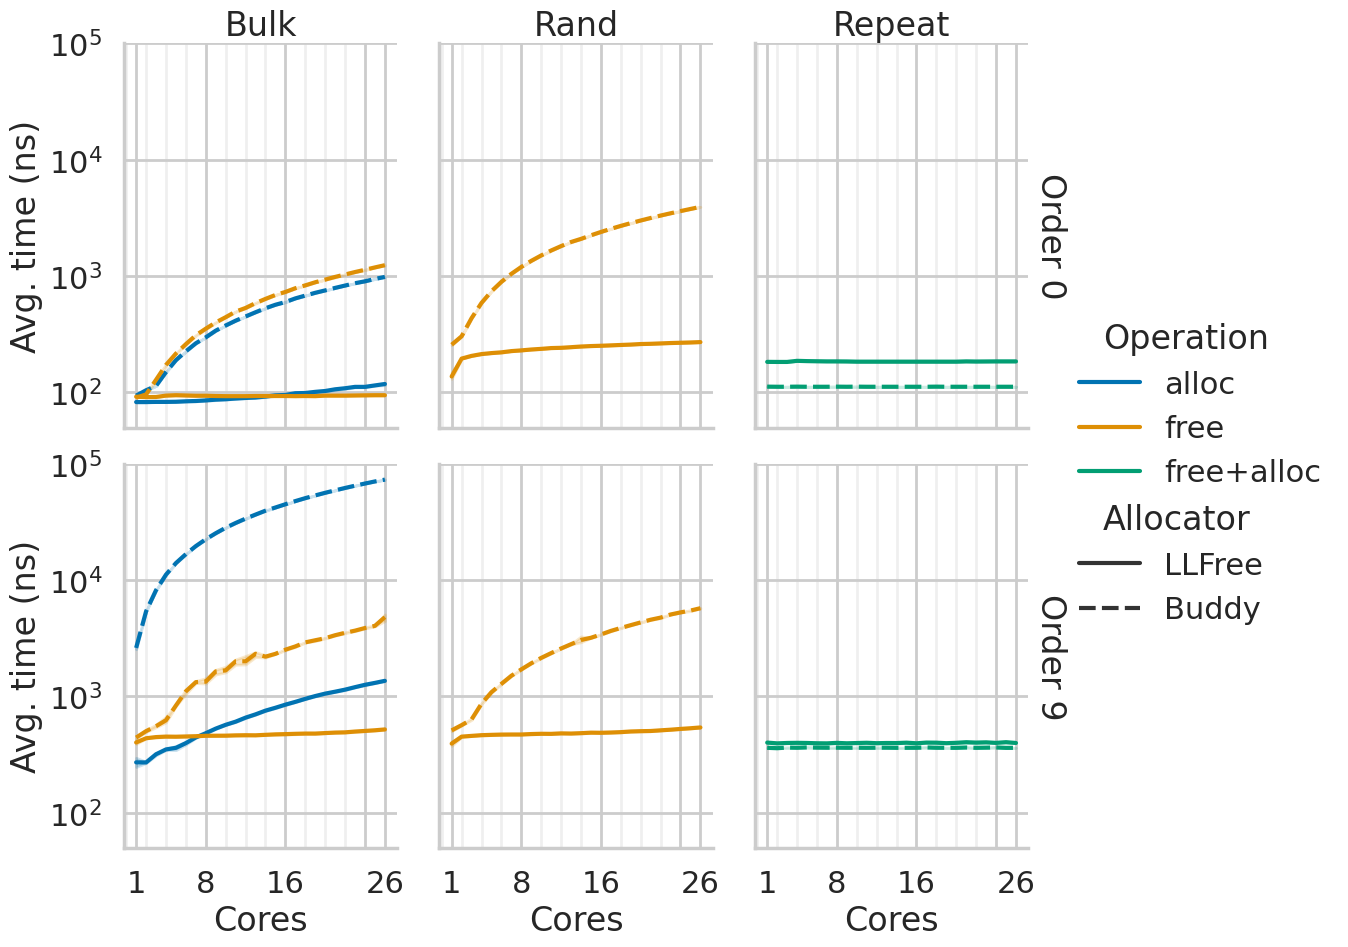

In [7]:
data_ll = read_all_bench(ll_c, [0, 9])
data_ll["Allocator"] = "LLFree"
data_bu = read_all_bench(bu_c, [0, 9])
data_bu["Allocator"] = "Buddy"

data_c = pd.concat([data_ll, data_bu], ignore_index=True)
pgd = data_c.melt(
    id_vars=["bench", "order", "cores", "Allocator"],
    value_vars=["alloc", "free", "free+alloc"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, row="order", col="bench", col_order=col_order,
                      height=5, aspect=0.8, margin_titles=True)
    g.map_dataframe(sns.lineplot, x="cores", y="time",
                    style="Allocator", hue="Operation")
    g.add_legend(adjust_subtitles=True)
    
    g.set(ylim=(50, 10**5))
    g.set(yscale="log")
    g.set(xticks=[1, 8, 16, 24, 26])
    for ax in g.axes_dict.values():
        ax.set_xticks(list(range(0, 27, 2)), minor=True)
        ax.set_yticks([], minor=True)
        ax.grid(which="minor", alpha=0.3)
    g.set(xticklabels=[1, 8, 16, "", 26])

    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Cores")
    g.set_titles(col_template="{col_name}", row_template="Order {row_name}")
    g.savefig("out/module_c.pdf")


save_dref("module_c", ["Allocator", "bench", "order", "cores", "Operation"], pgd)
